# Titanic ML competition

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## Overview

*(from https://www.kaggle.com/c/titanic/data)*

The data has been split into two groups:

* training set (`train.csv`)
* test set (`test.csv`)

The **training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The **test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include `gender_submission.csv`, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## Data dictionary

*(from https://www.kaggle.com/c/titanic/data)*

| Variable | Definition | Key |
| :------- | :------- | :------- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| name | Passenger's name | Last name - Title - Name(s) - (Nick name) |
| sex | Sex |   |
| Age | Age in years|   |
| sibsp | # of siblings / spouses aboard the Titanic |   |
| parch | # of parents / children aboard the Titanic |   |
| ticket | Ticket number |   |
| fare | Passenger fare	 |   |
| cabin | Cabin number	 |   |
| embarked | Port of Embarkation	 | C = Cherbourg, Q = Queenstown, S = Southampton |

## Variable Notes

*(from https://www.kaggle.com/c/titanic/data)*

**pclass**: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
+ Sibling = brother, sister, stepbrother, stepsister
+ Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Getting into the challenge!

From a typical Scikit-Learn workflow, we're going to follow these steps:

0. Standard library imports
1. Get the data ready
2. Pick a model/estimator
3. Fit the model to the data and make a prediction
4. Evaluate the model
5. Improve through experimentation
6. Submit predictions

### 0. Standard library imports

The most important libraries we'll going to use will be:

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Our Titanic case is a binary classification problem, ergo, will import some classification models for future testing:

> **Note:** as at 15/12/2021 CatBoost is not supported on Apple Silicon, where this notebook is being run, that's why it's commented for now. 

In [13]:
# Import models from sklearn
#import catboost
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier, Pool, cv

Lastly we'll need some extra tools for data manipulation from Scikit-Learn:

In [14]:
# Import aditional tools from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### 1. Get the data ready

This is a very important step because here we can certain treatments to the features in our data in order to take advantage on the processing in the following steps.

We'll import the data so as to start having a glimpse of it

In [15]:
# Import train and test csv from kaggle (previously downloaded to my hard drive)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


As we can see, we have 12 columns in the training split and 11 in the test split (`Survived` is not there). We'll pay special atention to some of these so as to leverage as most as data as possible.

In [18]:
# Get a description of the train data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
# Check NaN values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Some of our features are **numerical** (categorical or not), and some others are **strings**.

We'll analyse feature by feature.

#### 0. PassengerId

This one is not relevant, we'll drop this column.

In [21]:
X = train.drop("PassengerId", axis=1)
X.head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


#### 1. Survived

This column will be entirely the `y` set (labels or truth labels).

In [22]:
y = train["Survived"]
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

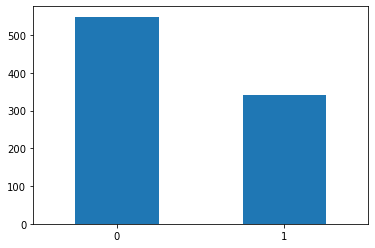

In [23]:
y.value_counts().plot.bar(rot=0);

#### 2. Pclass (Ticket class: 1st, 2nd or 3rd)

This feature is numerical, but still categorical. We'll need to one-hot-encode it, this means to split it into 3 columns each one representing a class, and just '1' or '0' if the passenger belongs (or doesn't) to that class.
Both Pandas and Scikit-Learn have one-hot-encoders, we'll use `get_dummies` from Pandas.

In [24]:
classes = pd.get_dummies(X.Pclass, prefix="Class")
classes

,Class_1,Class_2,Class_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1
...,...,...,...
886,0,1,0
887,1,0,0
888,0,0,1
889,1,0,0


In [25]:
classes.sum()

Class_1    216
Class_2    184
Class_3    491
dtype: int64

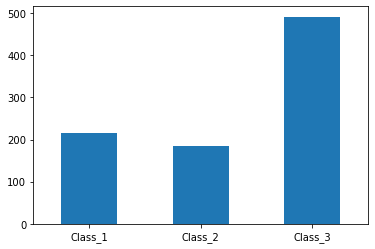

In [26]:
classes.sum().plot.bar(rot=0);

#### 3. Name

This feature seems not useful, but can be proccessed in order to be useful. If we pay atention, we have the `title` portion, from which we can leverage.

In [27]:
X.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

If we clean the surname, and all after the title we can have a useful feature. To split the complete name into elements, we access python's `str` method.

In [28]:
# Split words in name and make columns with the first and the rest of the split
name = X.Name.str.split(",", 0, expand=True)
# Drop the rest of the split
name.drop(0, axis=1, inplace=True)
name

,1
0,Mr. Owen Harris
1,Mrs. John Bradley (Florence Briggs Thayer)
2,Miss. Laina
3,Mrs. Jacques Heath (Lily May Peel)
4,Mr. William Henry
...,...
886,Rev. Juozas
887,Miss. Margaret Edith
888,"Miss. Catherine Helen ""Carrie"""
889,Mr. Karl Howell


In [29]:
name[1]

0                                  Mr. Owen Harris
1       Mrs. John Bradley (Florence Briggs Thayer)
2                                      Miss. Laina
3               Mrs. Jacques Heath (Lily May Peel)
4                                Mr. William Henry
                          ...                     
886                                    Rev. Juozas
887                           Miss. Margaret Edith
888                 Miss. Catherine Helen "Carrie"
889                                Mr. Karl Howell
890                                    Mr. Patrick
Name: 1, Length: 891, dtype: object

In [30]:
name = name[1].str.replace(" ", "").str.split(".").str[0]
name.value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
theCountess      1
Capt             1
Ms               1
Sir              1
Lady             1
Mme              1
Don              1
Jonkheer         1
Name: 1, dtype: int64

This way we have a name series to add to our features matrix. For now, we won't be able to use it, because we need to do the same treatment to the test set and this parsing may not be the same there. So we'll forget this.

#### 4. Sex

We need another one-hot-encoding for this one.

In [31]:
sex = pd.get_dummies(X.Sex)
sex.head()

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [32]:
sex.sum()

female    314
male      577
dtype: int64

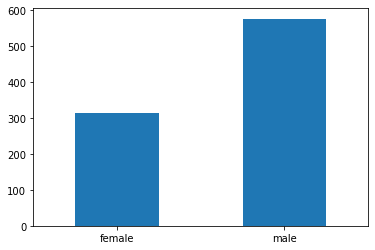

In [33]:
sex.sum().plot.bar(rot=0);

#### 5. Age

Age is a controversial one. It's a very important feature if we remember at that moment the famous "women and children first" phrase.
With this being said, let's remind ourselves the NaN situation with Age:

In [34]:
X.Age.isna().sum()

177

And the total lenght of the dataset was:

In [35]:
len(X), X.Age.isna().sum()/len(X)*100

(891, 19.865319865319865)

This means that we have missing values representing almost the 20% of the dataset. In these cases we can:
* Drop the column - loose the feature (technically called *Data Removal*)
* Fill the NaN values (technically called *Imputation*)

The second option has more options within.
Check out:
- https://www.mastersindatascience.org/learning/how-to-deal-with-missing-data/
- https://medium.com/@vinitasilaparasetty/guide-to-handling-missing-values-in-data-science-37d62edbfdc1

At this point we think there must be a correlation between the missing data on the **Age** feature and the **Pclass** value.

In [36]:
# Select only rows where Age = NaN
X[X["Age"].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
859,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [37]:
# From this selection, get the total from each class
X[X["Age"].isna()].Pclass.value_counts()

3    136
1     30
2     11
Name: Pclass, dtype: int64

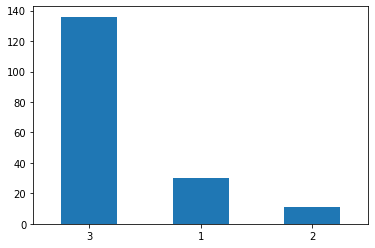

In [38]:
# Plot
X[X["Age"].isna()].Pclass.value_counts().plot.bar(rot=0);

So NaN values in age tend to be more common on people belonging to 3rd class.

Going back to *imputation* methods, there are a few, but we're going to try with the `median` value in all the dataset.

In [39]:
# Fill NaN values in Age column with median
X["Age"].fillna(X.Age.median(), inplace=True)

#### 6. SibSp

Reminder:
+ Sibling = brother, sister, stepbrother, stepsister
+ Spouse = husband, wife (mistresses and fiancés were ignored)

In [40]:
X.SibSp.describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

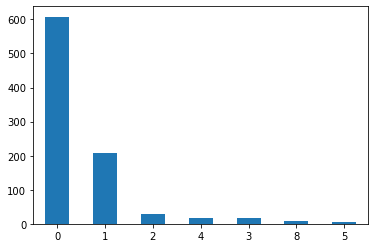

In [41]:
X.SibSp.value_counts().plot.bar(rot=0);

In [42]:
# Percentage of all dataset
X.SibSp.value_counts()/len(X)*100

0    68.237935
1    23.456790
2     3.142536
4     2.020202
3     1.795735
8     0.785634
5     0.561167
Name: SibSp, dtype: float64

So, a big part of these passengers were travelling alone, 68.24%. And a 23.46% travelled with just one companion.
We have a numerical feature, with no missing values, which is very good for the modelling. This feature needs no preprocessing, we'll continue with the next one.

#### 7. Parch

This one refered to family relations:

- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them

In [43]:
X.Parch.describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

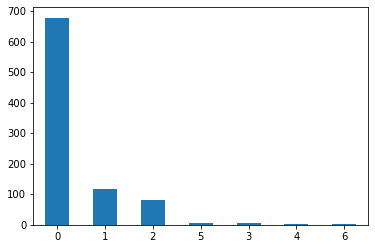

In [44]:
X.Parch.value_counts().plot.bar(rot=0);

Same as before, full numerical, no need to preprocess.

#### 8. Ticket

Ticket is a object type feature. It has many different values among the dataset (681). At this first stage won't help us.

In [45]:
X.Ticket.describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

#### 9. Fare

So Fare is a numerical feature, we've no missing values, so we're good to go.

**Note:** we can consider in the future, to normalize this column, so as to ensure all values live between 0 and 1. This is better for the model to look for patterns.

In [46]:
X.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [47]:
X.Fare.isna().sum()

0

#### 10. Cabin

Let's see this feature.

In [48]:
X.Cabin.describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [49]:
X.Cabin.isna().sum()/len(X)

0.7710437710437711

We have a lot of NaN values, almost 80%. This won't be of any help. We can drop the column

#### 11. Embarked

This feature indicates where the passenger boarded the Titanic. It has only two missing values in all the dataset, and has three unique values:
* C = Cherbourg
* Q = Queenstown
* S = Southampton

With this information we can one-hot-encode this feature, similar to what we did with `Pclass`.

Manage of the NaN values:
* Drop the two rows
* Fill with random value

Anyways this may not be so important for the model itself. We'll see.

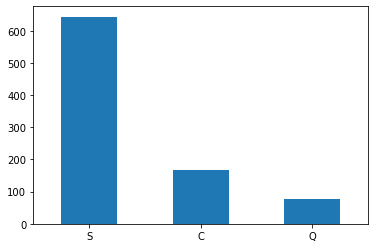

In [50]:
X.Embarked.value_counts().plot.bar(rot=0);

In [51]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Summing up

Columns we'll drop:
* PassengerId
* Survived
* Name
* Ticket
* Cabin

Features we'll preprocess:
* Pclass --> one-hot-encode
* Sex --> one-hot-encode
* Age --> fill NaN with median
* Embarked --> fill NaN with random value, one-hot-encode

Features we'll keep the same:
* SibSp
* Parch
* Fare

💡 **Investigate**: `pd.get_dummies` dummy_na --> Add a column to indicate NaNs, if False NaNs are ignored.

For the sake of clearness, we'll do everything in the following cells.

In [52]:
# Drop irrelevant columns
drop = ["PassengerId", "Survived", "Name", "Ticket", "Cabin"]
X = train.drop(drop, axis=1)

In [53]:
# Fillna Age column
X["Age"].fillna(X["Age"].median(), inplace=True)

In [54]:
# # Parse 'Name' column
# # Split words in name and make columns with the first and the rest of the split
# name = X.Name.str.split(",", 0, expand=True)
# # Drop the rest of the split
# name.drop(0, axis=1, inplace=True)
# # Parse spaces and save title
# name = name[1].str.replace(" ", "").str.split(".").str[0]
# # Replace this new column in X dataframe
# X["Name"] = name

In [55]:
# Fillna Embarked with random value
embarked = ["S", "C", "Q"]
X.Embarked.fillna(np.random.choice(embarked).astype(str), inplace=True)

In [56]:
# One-hot-encode
X = pd.get_dummies(X, columns=["Pclass", "Embarked", "Sex"])
X

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,0,0,1,1,0
3,35.0,1,0,53.1000,1,0,0,0,0,1,1,0
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,0,1,0,0,0,1,0,1
887,19.0,0,0,30.0000,1,0,0,0,0,1,1,0
888,28.0,1,2,23.4500,0,0,1,0,0,1,1,0
889,26.0,0,0,30.0000,1,0,0,1,0,0,0,1


In [57]:
# Define y set (truth labels)
y = train.Survived

Okey!!! We've finished getting the data ready. Remember that the test set must have the same format, so we'll need to do the same treatment to it. We'll do that now.

In [58]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [59]:
# Drop irrelevant columns
#test = test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
# Fillna Age column
test["Age"].fillna(test["Age"].median(), inplace=True)
# Fillna Fare column
test["Fare"].fillna(test["Fare"].median(), inplace=True)
# Fillna Embarked with random value
embarked = ["S", "C", "Q"]
test.Embarked.fillna(np.random.choice(embarked).astype(str), inplace=True)
# One-hot-encode
test = pd.get_dummies(test, columns=["Pclass", "Embarked", "Sex"])
test

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,0,1,0,1,0,0,1
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,0,0,1,0,0,1,1,0
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,0,1,0,0,1
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,1,0,0,1,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,"Spector, Mr. Woolf",27.0,0,0,A.5. 3236,8.0500,NaN,0,0,1,0,0,1,0,1
414,1306,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,0,0,1,0,0,1,0
415,1307,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,0,1,0,0,1,0,1
416,1308,"Ware, Mr. Frederick",27.0,0,0,359309,8.0500,NaN,0,0,1,0,0,1,0,1


In [60]:
test.isna().sum()

PassengerId      0
Name             0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Pclass_1         0
Pclass_2         0
Pclass_3         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Sex_female       0
Sex_male         0
dtype: int64

### 2. Pick a model/estimator

Ok, let's remind ourselves what kind of problem are we attacking. This one is a **Classification** problem, ergo, we need Classification models.

There are a bunch of them, but if we use scikit-learn's [guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we can reduce our alternatives.

But for this trial, we'll compare:

1. LinearSVC
2. KNeighborsClassifier
3. SVC
4. LogisticRegression
5. RandomForestClassifier
6. CatBoostClassifier

#### CatBoost install
https://catboost.ai/en/docs/installation/python-installation-method-conda-install
    

### 3. Fitting a model and score (predict + evaluate)

We'll make a function to perform this actions on all the models

The steps we need to carry out for each model are:
* Instantiate model
* Fit model
* Score (predict + evaluate)
* Cross-validate (10 folds)
    * Accuracy
    * Precision
    * Recall
    * F1
* Time the process in all cases

In [61]:
# Instantiate all models in a dictionary
models = {
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
}

In order to fit the models, we need a train and test set. To acomplish that, we'll use scikit-learn's `train_test_split` function.

In [62]:
# Make train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((757, 12), (134, 12), (757,), (134,))

In [63]:
# Set random seed
np.random.seed(42)

# Fit and score models, save results in dictionary
results = {}
for model_name, model_instance in models.items():
    model_instance.fit(X_train, y_train)
    results[model_name] = np.round(model_instance.score(X_test, y_test), 4)
    

/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=["Accuracy"])
results_df

,Accuracy
LinearSVC,0.6269
KNN,0.7612
SVC,0.6567
LogisticRegression,0.8060
RandomForestClassifier,0.8284


In [65]:
# Cross-validation with all metrics and all models
# Set random seed
np.random.seed(42)

scorings = ["accuracy", "recall", "precision", "f1"]
results_cv = {  
    "LinearSVC": {},
    "KNN": {},
    "SVC": {},
    "LogisticRegression": {},
    "RandomForestClassifier": {}}

for model_name, model_instance in models.items():
    for score in scorings:
        results_cv[model_name][score] = (np.mean(cross_val_score(model_instance, X, y, cv=10, scoring=score)))

/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marcosfiesta/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

In [66]:
results_df = pd.DataFrame(results_cv.values(), index=results_cv.keys(), columns=scorings)
results_df

,accuracy,recall,precision,f1
LinearSVC,0.685680,0.695378,0.775687,0.613082
KNN,0.715019,0.576134,0.646908,0.606289
SVC,0.681323,0.301597,0.691197,0.415718
LogisticRegression,0.798002,0.698655,0.759211,0.724468
RandomForestClassifier,0.812659,0.725126,0.755084,0.745273


#### 6. CatBoostClassifier

CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

In [67]:
# View the data for the CatBoost model
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,0,0,1,1,0
3,35.0,1,0,53.1000,1,0,0,0,0,1,1,0
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,1


In [68]:
# View the labels for the CatBoost model
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [69]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X.dtypes != np.float)
cat_features

(array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11]),)

In [70]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X, 
                  y,
                  cat_features)

NameError: name 'Pool' is not defined

In [ ]:
np.random.seed(42)

# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=False)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(train.drop("Survived", axis=1), y) * 100, 2)

In [ ]:
np.random.seed(42)

# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

In [ ]:
acc_catboost, acc_cv_catboost, catboost_time

**CatBoostClassfier** and **RandomForestClassifier** give the best results, so we'll continue with these models.

### 4. Hyperparameter tuning

For this instance, we're going to use GridSearchCV in order to get the best hyperparameters.

In [ ]:
# Define hyperparameter dictionary for GridSearchCV
grid = {
    "n_estimators":[100, 500, 1000],
    "max_depth":[None, 5, 30],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 4]
}

# Instantiate classifier
clf = RandomForestClassifier(n_jobs=-1)

# Setup GridSearchCV
gs_clf = GridSearchCV(clf, grid, scoring="f1", n_jobs=-1, cv=10, verbose=2)

# Fit train_data
gs_clf.fit(X_train, y_train)

# Score
gs_clf.score(X_test, y_test)

In [ ]:
gs_clf.best_params_

Refit with all dataset

In [ ]:
clf = RandomForestClassifier(n_estimators=500,
                       max_depth=30,
                       max_features='sqrt',
                       min_samples_leaf=2,
                       min_samples_split=4)

In [ ]:
clf.fit(X, y)

### 6. Submit predictions

In [ ]:
X.columns

In [ ]:
# Make predictions with best_params on wanted columns
predictions = clf.predict(test[X.columns])

In [ ]:
# See predictions
predictions[:20]

In [ ]:
len(predictions)

In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

In [ ]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('RFC_submission.csv', index=False)
print('Submission CSV is ready!')